In [25]:
import sys
import os
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

from quant.Classification import Classification
from quant.factor import get_factors
from tqdm import tqdm

import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

np.set_printoptions(precision=4, suppress=True)

import warnings
warnings.filterwarnings('ignore')

In [3]:
klines_1h_file = 'data/futures_klines_1h_BTCUSDT_20200101_20220430.zip'
kline_1h_df = pd.read_csv(klines_1h_file, index_col=0, parse_dates=True)
kline_1h_factors = get_factors(kline_1h_df, sign_ratio=1)

In [4]:
X = kline_1h_factors.drop(['Price', 'Returns', 'CumReturns', 'Log_Returns', 'Returns_Ratio', 'Sign'], axis=1)
y = kline_1h_factors['Sign']
X.shape, y.shape

((20217, 18), (20217,))

[Text(334.8, 326.15999999999997, 'X[7] <= -24.605\ngini = 0.5\nsamples = 20217\nvalue = [9872, 10345]'),
 Text(167.4, 108.72000000000003, 'gini = 0.493\nsamples = 8322\nvalue = [3663, 4659]'),
 Text(502.20000000000005, 108.72000000000003, 'gini = 0.499\nsamples = 11895\nvalue = [6209, 5686]')]

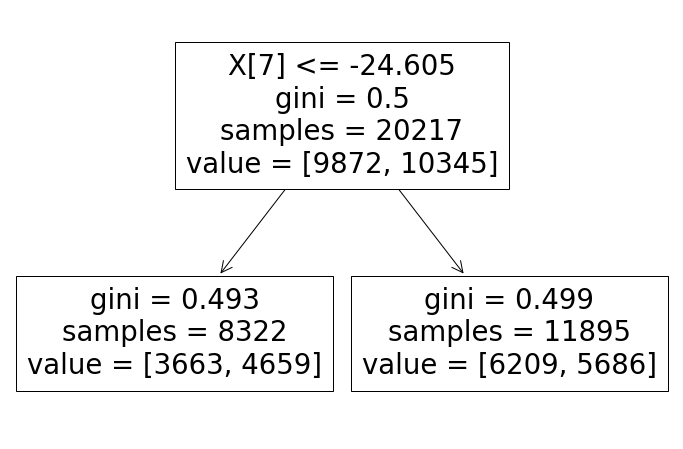

In [7]:
from sklearn import tree

dtc = DecisionTreeClassifier(criterion='gini',
                             max_depth=1,
                             max_features=6,
                             min_samples_leaf=1,
                             min_samples_split=2,
                             random_state=64,
                             ccp_alpha=0)
dtc.fit(X, y)

plt.figure(figsize=(12, 8))
tree.plot_tree(dtc)

In [44]:
dt_1 = Classification(X, y, test_size=0.5)
dt_1.fit_predict(
    MinMaxScaler(),
    DecisionTreeClassifier(criterion='gini',
                            max_depth=5,
                            max_features=6,
                            min_samples_leaf=1,
                            min_samples_split=6,
                            random_state=64,
                            ccp_alpha=0))
mse, rmse, r2train, r2test = dt_1.eval_metrics()
mse, rmse, r2train, r2test

(0.47452764862993374,
 0.6888596726692119,
 0.5602493074792244,
 0.5254723513700663)

In [43]:
dt_2 = Classification(X, y, test_size=0.5)
dt_2.fit_predict(
    MinMaxScaler(),
    DecisionTreeClassifier(criterion='gini',
                            max_depth=1,
                            max_features=6,
                            min_samples_leaf=1,
                            min_samples_split=2,
                            random_state=64,
                            ccp_alpha=0))
best_mse, best_rmse, best_r2train, best_r2test = dt_2.eval_metrics()
best_mse, best_rmse, best_r2train, best_r2test

(0.46829557819764567,
 0.6843212536503931,
 0.5457063711911357,
 0.5317044218023543)

Text(0.5, 1.0, 'Confusion Matrix II')

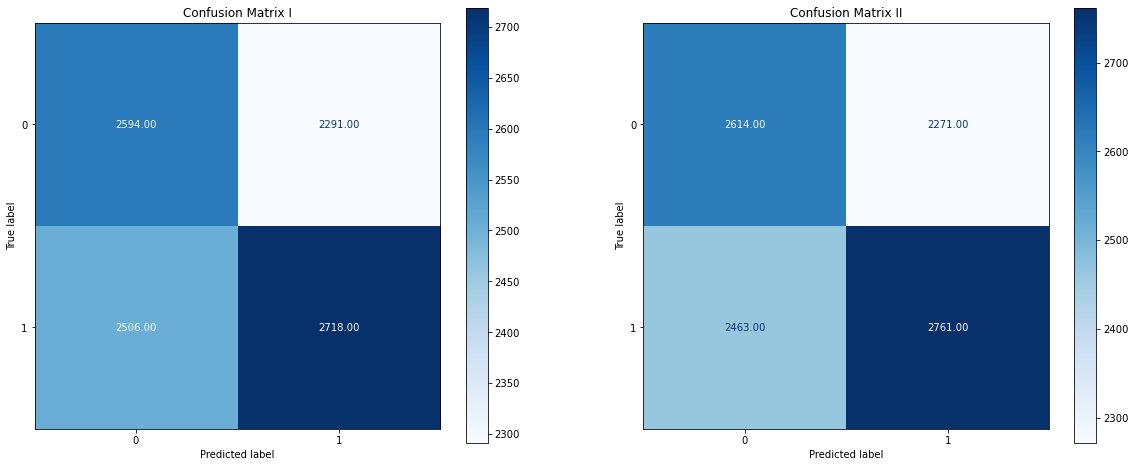

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

plot_confusion_matrix(dt_1.pipe, dt_1.X_test, dt_1.y_test, ax=ax[0], cmap='Blues', values_format='.2f')
ax[0].set_title('Confusion Matrix I')

plot_confusion_matrix(dt_2.pipe, dt_2.X_test, dt_2.y_test, ax=ax[1], cmap='Blues', values_format='.2f')
ax[1].set_title('Confusion Matrix II')

Text(0.5, 1.0, 'Receiver Operating Characteristic for Up Moves II')

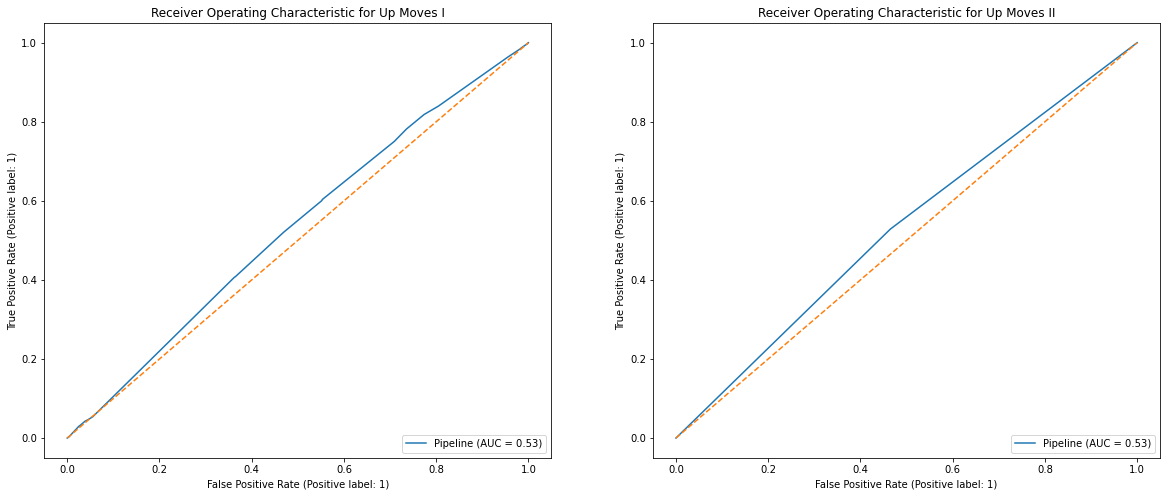

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Random Prediction
r_prob_1 = [0 for _ in range(len(dt_1.y_test))]
r_fpr_1, r_tpr_1, _ = roc_curve(dt_1.y_test, r_prob_1, pos_label=1)

plot_roc_curve(dt_1.pipe, dt_1.X_test, dt_1.y_test, ax=ax[0])
ax[0].plot(r_fpr_1, r_tpr_1, linestyle='dashed', label='Random Prediction')
ax[0].set_title('Receiver Operating Characteristic for Up Moves I')

# Random Prediction
r_prob_2 = [0 for _ in range(len(dt_2.y_test))]
r_fpr_2, r_tpr_2, _ = roc_curve(dt_2.y_test, r_prob_2, pos_label=1)

# Plot ROC Curve
plot_roc_curve(dt_2.pipe, dt_2.X_test, dt_2.y_test, ax=ax[1])
ax[1].plot(r_fpr_2, r_tpr_2, linestyle='dashed', label='Random Prediction')
ax[1].set_title('Receiver Operating Characteristic for Up Moves II')


In [52]:
# Result
pd.set_option('display.float_format', lambda x: '%.8f' % x)
result = pd.DataFrame()
result = result.append([['Test I', 5, 6, mse, rmse, r2train, r2test]])
result = result.append([['Test II', 1, 2, best_mse, best_rmse, best_r2train, best_r2test]])

result.columns = ['Test', 'max_depth', 'min_samples_split', 'MSE', 'RMSE', 'R2Train', 'R2Test']
result.reset_index(drop=True, inplace=True)
print(result.to_latex(index=False))
result

\begin{tabular}{lrrrrrr}
\toprule
   Test &  max\_depth &  min\_samples\_split &        MSE &       RMSE &    R2Train &     R2Test \\
\midrule
 Test I &          5 &                  6 & 0.47452765 & 0.68885967 & 0.56024931 & 0.52547235 \\
Test II &          1 &                  2 & 0.46829558 & 0.68432125 & 0.54570637 & 0.53170442 \\
\bottomrule
\end{tabular}



,Test,max_depth,min_samples_split,MSE,RMSE,R2Train,R2Test
0,Test I,5,6,0.47452765,0.68885967,0.56024931,0.52547235
1,Test II,1,2,0.46829558,0.68432125,0.54570637,0.53170442
